In [6]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.io import imsave
import numpy as np
import os
import random
import tensorflow as tf
from tensorflow.keras.layers import (BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [9]:
#Getting Images

X = []
newsize = (256, 256)

for filename in os.listdir('/content/image/'):
  im1 = load_img('/content/image/'+filename)
  resizedImage = im1.resize(newsize)
  X.append(img_to_array(resizedImage))

X = np.array(X, dtype=float)


# Set up train and test data

split = int(0.95*len(X))
Xtrain = X[:split]
Xtrain = 1.0/255*Xtrain
Xtrain.shape

(589, 256, 256, 3)

In [10]:
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import Activation, Dense, Dropout, Flatten, InputLayer
from tensorflow.keras.layers import (BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense)
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.models import Sequential

model = Sequential()

#Input Layer
model.add(Conv2D(64, (3, 3), input_shape=(256, 256, 1), activation='relu', padding='same'))

#Hidden Layers
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))

#Compiling the CNN
model.compile(optimizer='rmsprop', loss='mse', metrics = ['accuracy'])

In [19]:
import matplotlib.pyplot as plt

# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

# Generate training data
batch_size = 10
def image_a_b_gen(batch_size):
    for batch in datagen.flow(Xtrain, batch_size=batch_size):
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield (X_batch.reshape(X_batch.shape+(1,)), Y_batch)

# Train model      
#tensorboard = TensorBoard(log_dir="/output/beta_run")
trainedmodel = model.fit_generator(image_a_b_gen(batch_size),epochs=200, steps_per_epoch=30)




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/200
30/30 [==============================] - 8s 273ms/step - loss: 0.0086 - accuracy: 0.6205
Epoch 2/200
30/30 [==============================] - 8s 271ms/step - loss: 0.0097 - accuracy: 0.5898
Epoch 3/200
30/30 [==============================] - 9s 304ms/step - loss: 0.0093 - accuracy: 0.6278
Epoch 4/200
30/30 [==============================] - 8s 272ms/step - loss: 0.0077 - accuracy: 0.6105
Epoch 5/200
30/30 [==============================] - 9s 309ms/step - loss: 0.0084 - accuracy: 0.6048
Epoch 6/200
30/30 [==============================] - 8s 272ms/step - loss: 0.0094 - accuracy: 0.6155
Epoch 7/200
30/30 [==============================] - 8s 272ms/step - loss: 0.0088 - accuracy: 0.6132
Epoch 8/200
30/30 [==============================] - 8s 271ms/step - loss: 0.0085 - accuracy: 0.6247
Epoch 9/200
30/30 [==============================] - 8s 275ms/step - loss: 0.0082 - accuracy: 0.6213
Epoch 10/200
30/30 [==============================] - 8s 271ms/step - loss: 0.0080 - accura

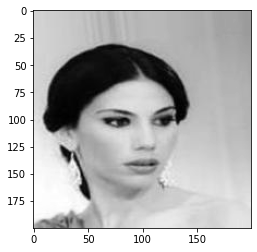

In [9]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

for i in range(50,58):
    f = "/content/image/0000"+ str(i) + ".jpg"
    image = mpimg.imread(f)
    gray = rgb2gray(image)
    plt.imshow(gray, cmap = plt.get_cmap('gray'))
    plt.savefig( "/content/test3/fw"+ str(i) + ".jpg")

In [38]:
color_me = []

newsize = (256, 256)


for filename in os.listdir('/content/test3/'):
  im1 = load_img('/content/test3/'+filename)
  resizedImage = im1.resize(newsize)
  color_me.append(img_to_array(resizedImage))

color_me = np.array(color_me, dtype=float)
color_me = rgb2lab(1.0/255*color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape+(1,))

# Test model
output = model.predict(color_me)
output = output * 128

# Output colorizations
for i in range(len(output)):
    cur = np.zeros((256, 256, 3))
    cur[:,:,0] = color_me[i][:,:,0]
    cur[:,:,1:] = output[i]
    imsave("/content/res/img_"+str(i)+".png", lab2rgb(cur))

In [37]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save("model.h5")